# Network Based Imitation

Notebook originally created to implement network based imitatation strategy model found on pages 100-103 of D. Sornette's "Why Stock Markets Crash" book. Original paper written by ... unsure will investigate later I want to start programming.

In [1]:
import warnings
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

warnings.filterwarnings('ignore')

___
## Math definitions
* $I$ - the number of traders in the network. In this case $I=100$.
* $i$ - the index used to denote an individual trader. $i=0,\dots,I-1$.
* $N(i)$ - number of traders directly connected to trader $i$. In other words, the number of "neighbors" of trader $i$.
* $s_i$ - a certain trader's belief about the state of the market. Can take on two values:
  * $s_i=+1$ means the investor is feeling *good* about the market and wishes to buy.
  * $s_i=-1$ means the investor is feeling *bad* about the market and wishes to sell.
* $p(t-1)$ is the price of the asset at time $t-1$
* Price variation is then just the aggregate sum of all trader's buy/sell decisions from the previous time period $\sum_{i=1}^N s_i(t-1)$. If this sum is zero then we had an equal numbers of buyers and sellers last round. We add a stochastic element to this equation for some spice, bringing it to $\sum_{i=1}^N s_i(t-1) + \sigma$ where $\sigma$ is our stochastic component.
* A trader updates there belief based on the equation $s_i(t-1)=\mathrm{sign}(K\sum_{j\in N(i)} s_j + \epsilon_i)$. In English this is the sum of all their neighbors beliefs plus a stochastic element to represent any anamolous information signals they recieve. The stochastic element keeps the network from total convergence.



___
## Function definitions

#### __Define__ `assign_random_market_beliefs`

We'll generate random +1/-1 attributes for each of the nodes to specify "bullish" or "bearish" (respectively). 

This is each trader's $s_i$ value. Can be thought of as $s_i=+1$ is the "buy state" and $s_i=-1$ is the "sell state."

In [2]:
def assign_random_market_beliefs(trader_network):
    random_market_beliefs = np.random.randint(2, size=len(trader_network))
    random_market_beliefs[random_market_beliefs == 0] = -1
    trader_beliefs = dict(zip(trader_network.nodes, random_market_beliefs))
    node_attrs = {trader_id : {'belief': trader_belief} for trader_id, trader_belief in trader_beliefs.items()}
    nx.set_node_attributes(trader_network, node_attrs)

#### __Define__ `generate_network`
We will be using the Barabasi-Albert random graph as this has a nice semi-realistic distribution of neighbors similar to a real world network.
* ~~This may be jumping the gun and we might want a simpler graph model, but this is where I'll start.~~

Was not jumping the gun, works great!

In [3]:
# Light wrapper to generate Barabasi-Albert graph
def generate_network(I=100, starting_edges=10):
    random_graph = nx.barabasi_albert_graph(I, starting_edges)
    assign_random_market_beliefs(random_graph)
    return random_graph

#### __Define__ `stochastic_var`

Very simple function that generates a random variable within the open interval $(-\mathrm{spread},\mathrm{spread})$.
* tiebreaks go to +1

In [4]:
def stochastic_var(spread):
    return (-1 if np.random.randn() < 0 else 1)*np.random.randint(spread, dtype=int)

#### __Define__ `calc_asset_price_variation`
This function computes the asset pricing movement from timestep $t-1$ to $t$ based on trader beliefs in the network and a stochastic component $\sigma$ thrown in for some spice. Stochastic var will be on closed interval $[-5,5]$ by default, just cause it's convinient for a hundred person network.

In [5]:
def calc_asset_price_variation(G, sigma=6):
    return sum(nx.get_node_attributes(trader_network, 'belief').values()) + stochastic_var(sigma) # remember the random generator is max exclusive

#### __Define__ `poll_neighbors`

This function is the update function for a *single* trader's belief value. It is equivalent to computing the function 
$$s_i=\mathrm{sign}(K\sum_{j\in N(i)} s_j + \epsilon_i)$$
where $K$ is our constant of proportionality that is based on "market depth," $N(i)$ are the neighbors of trader $i$, and $\epsilon_i$ is the stochastic variable that lets a trader go against the majority of her friends.
* $K$ is neccessary so we don't have wild price swings that are oversized for the price of our security. Say a trader has 50 neighbors, that sum will be very large and a small stochastic variable will not be able to overcome it. (__I've actually inverted the concept because I wasn't following the book closely, I encoded this in the `individuality` parameter which essentially accomplishes the same function__).

In [6]:
def poll_neighbors(trader, individuality=50):
    neighbor_polled_sum = 0
    for neighbor in nx.neighbors(trader_network, trader):
        neighbor_polled_sum += trader_network.nodes[neighbor]['belief'] 
    return -1 if (neighbor_polled_sum + stochastic_var(individuality)) < 0 else 1 # The stochastic var here has to be high enough so that some trader's 

#### __Define__ `update_beliefs`
This function updates the beliefs of *all* traders in the network as a batch operation. Calling this function is equivalent to moving us one step forward in time from time $t-1$ to time $t$.

In [7]:
def update_beliefs(trader_network, individuality=50):
    nx.set_node_attributes(trader_network, 
                           {trader_id : {'belief': poll_neighbors(trader_id, individuality)} 
                            for trader_id in trader_network.nodes})

#### __Define__ `plot_trader_beliefs`
Helper function that let's us visualize trader network with color coded labels.
* __Green__ for "buy state" $s_i=+1$
* __Red__ for "sell state" $s_i=-1$

*(Not advisable when networks get large)*

In [8]:
def plot_trader_beliefs(G):
    fig= plt.figure(figsize=(12,8))
    color_map = ['red' if belief < 0 else 'green' for belief in nx.get_node_attributes(G, 'belief').values()]
    nx.draw(G, node_color=color_map, labels=nx.get_node_attributes(G, 'belief'))
    plt.title('Trader Belief Network', fontdict={'fontsize': 20})

___
# Experiment Space

### Start by using the default network

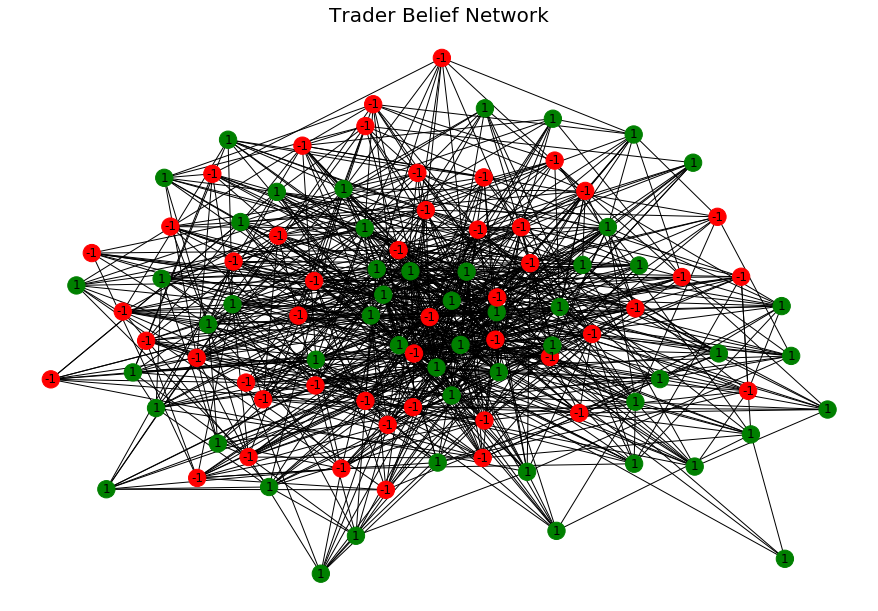

In [9]:
trader_network = generate_network()
plot_trader_beliefs(trader_network)

The above network represents the original state $t=0$ of trader's randomly generated beliefs about the market.

Let's plot the degree distribution just to show we have a decent looking distribution.

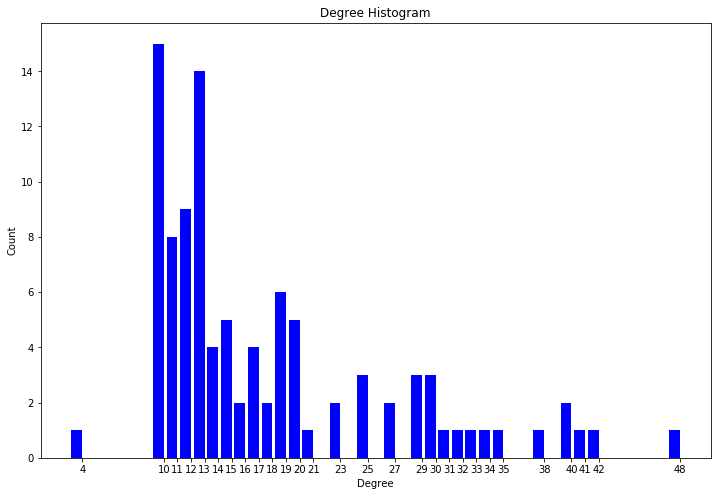

In [10]:
degrees = np.array(trader_network.degree)[:,1]
degrees = sorted(degrees, reverse=True)
degreeCount = Counter(degrees)
deg, cnt = zip(*degreeCount.items())

fig = plt.figure(figsize=(12,8))
ax = fig.gca()
plt.bar(deg, cnt, width=0.80, color='b')
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree");
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg);

Sweet this exponential-ish downcurve is just what we'd expect from the preferential attatchment (Barabasi-Albert) model.

Let's pick a random trader to check and make sure the belief attributes were set correctly.

In [11]:
random_trader = np.random.choice(trader_network.nodes)
print(f"Trader #{random_trader}'s belief about the market:")
trader_network.nodes[np.random.choice(trader_network.nodes)]['belief']

Trader #74's belief about the market:


1

In [12]:
# The `individuality` number here has to be a high enough number so the stochastic_var return value has the
# chance of flipping the trader against what his or her neighbors think. If the number is too low, the network
# shows total convergence and the price series is just a straight increasing line upward in time.
# In a 100 person network: 
#    0 gives us total opinion convergence and the price moves with the number of people in the network
#        plus the stochastic element, no good.
#    100 gives us too many insatnces where the price dips negative, also no good.
#    

We are going to run each simulation forward for 250 time steps for varying levels of `individuality`.

This first example shows the first extreme where `individuality = 1`. This corresponds to absolutely convergent behavior, as you'll see.

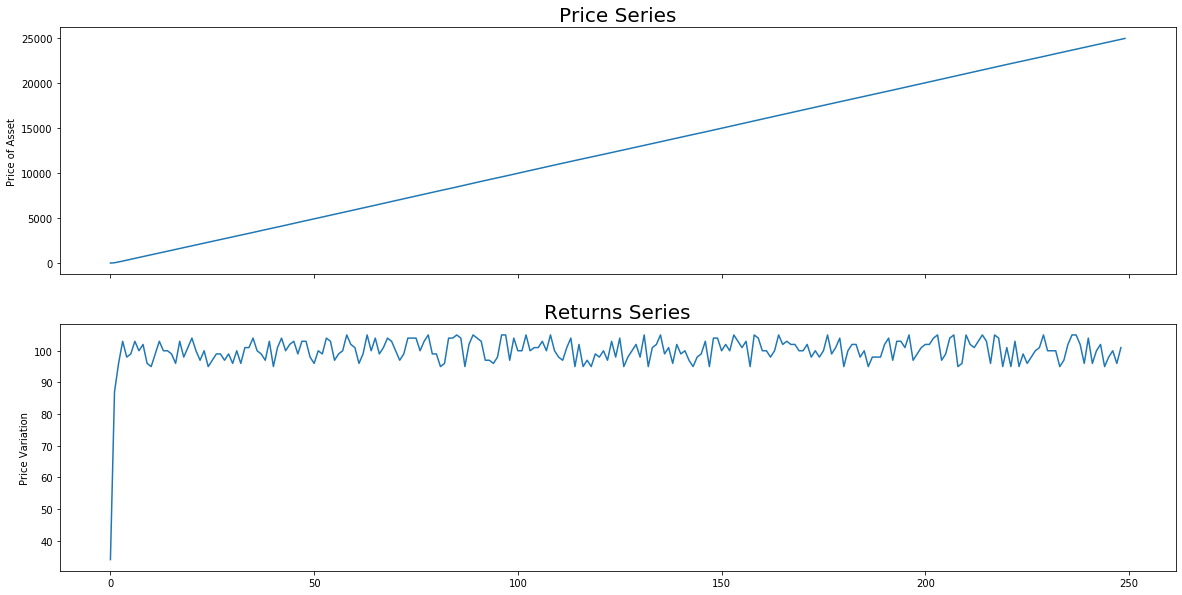

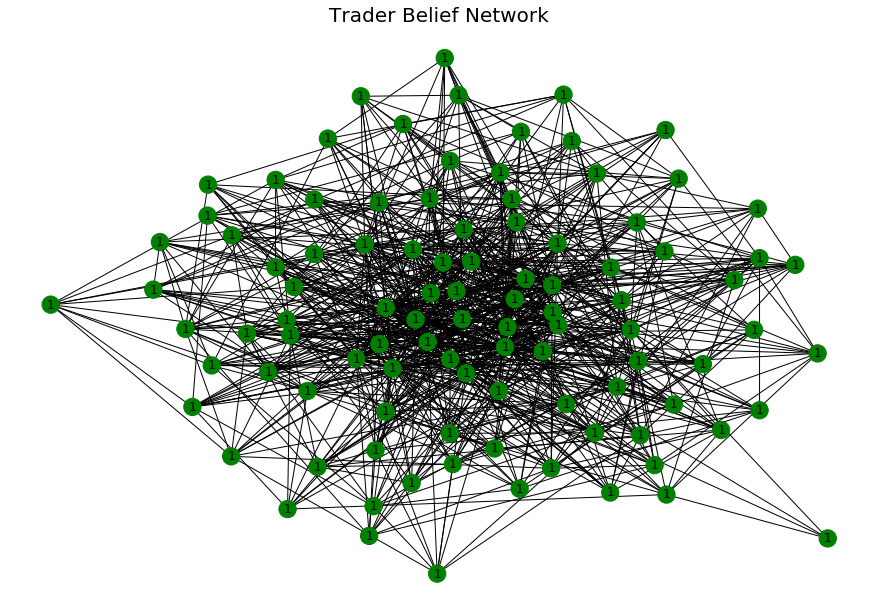

In [13]:
def run_simulation(individuality, initial_security_price=20, timesteps=250):
    price_movements = np.zeros(timesteps, dtype=int)
    price_series = np.zeros(timesteps, dtype=int)
    price_series[0] = initial_security_price

    for t in range(1,timesteps):
        update_beliefs(trader_network, individuality=individuality)

        price_variation = calc_asset_price_variation(trader_network)
        next_price = price_series[t-1] + price_variation

        price_movements[t-1] = price_variation
        price_series[t] = 0 if next_price < 0 else next_price # crudely gaurd against negative prices

    fig, (ax1, ax2) = plt.subplots(figsize=(20,10),nrows=2,ncols=1,sharex=True)
    ax1.plot(range(price_series.size), price_series)
    ax1.set_title("Price Series", fontdict={'fontsize':20})
    ax1.set_ylabel("Price of Asset", fontdict={'fontsize':10})
    ax2.plot(range(price_movements.size-1), price_movements[:-1])
    ax2.set_title("Returns Series", fontdict={'fontsize':20})
    ax2.set_ylabel("Price Variation", fontdict={'fontsize':10})
    plot_trader_beliefs(trader_network)
    
run_simulation(individuality=1)

Notice the fact that __all__ of the traders in the network end up in the "buy state" as the price shoots up indefinitely. This is not a coincidence and no individuality produces an incredible alignment of behavior.

*__sidenote:__* Not a huge fan of this because of how closely returns follows the random walk. I wish it had some volatility clustering like the real world, but you can't have it all and volatility clustering will be another notebook.

Moving on, we regenerate the network and run other `individuality` parameters. One thing I notice is that the smaller the `individuality` param, the more groupthink and thus 
1. the straighter the price series line. 
2. the returns converge around the *number of traders in the network*. (still can see the random element but mean is obviously $I$)

Let's do a few more individuality measures by regenerating the network and re-running the simulation

    individuality = 30

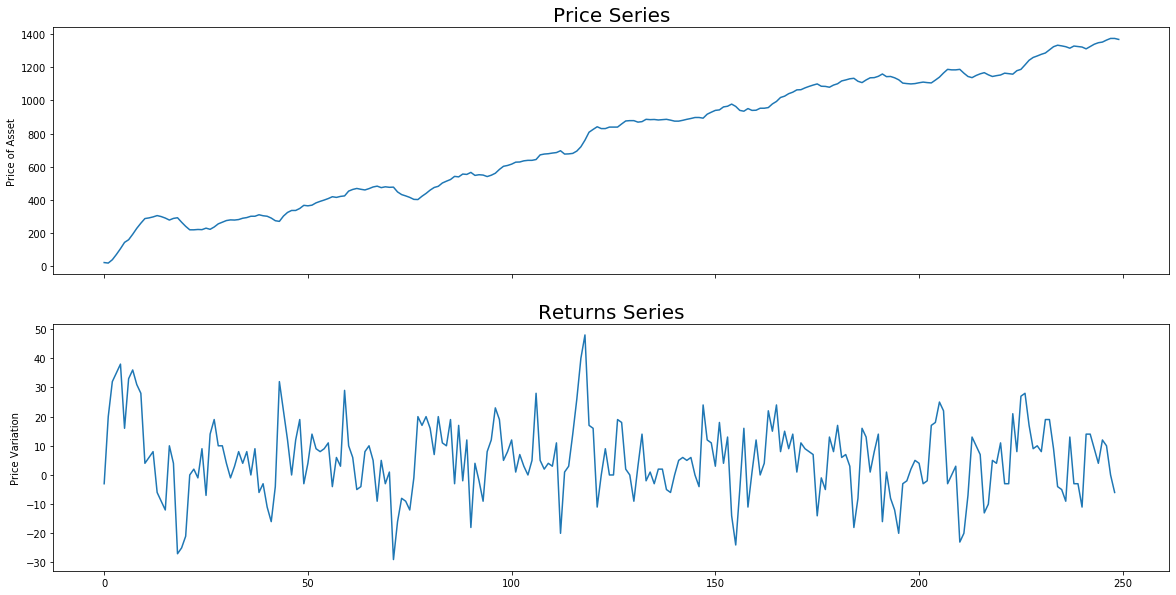

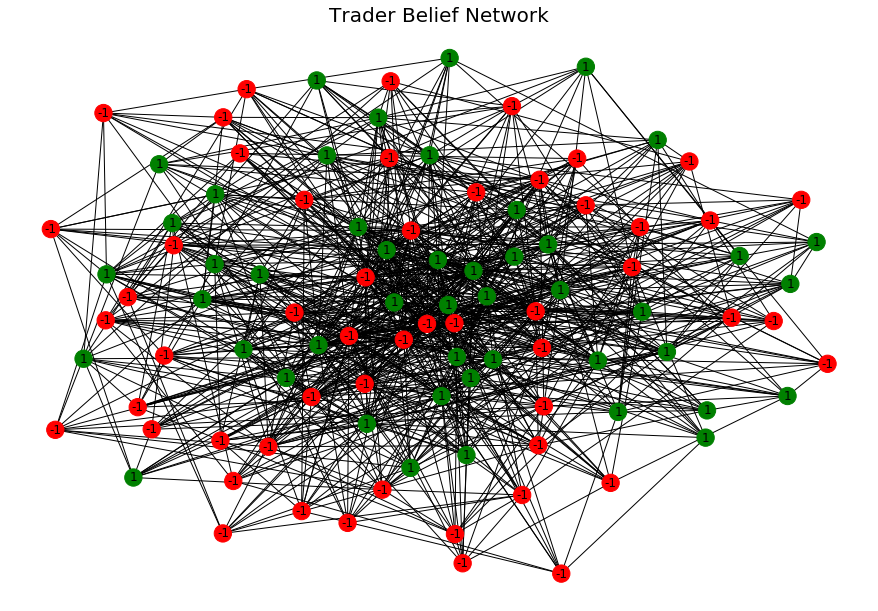

In [14]:
trader_network = generate_network()
run_simulation(individuality=33)

    individuality=50

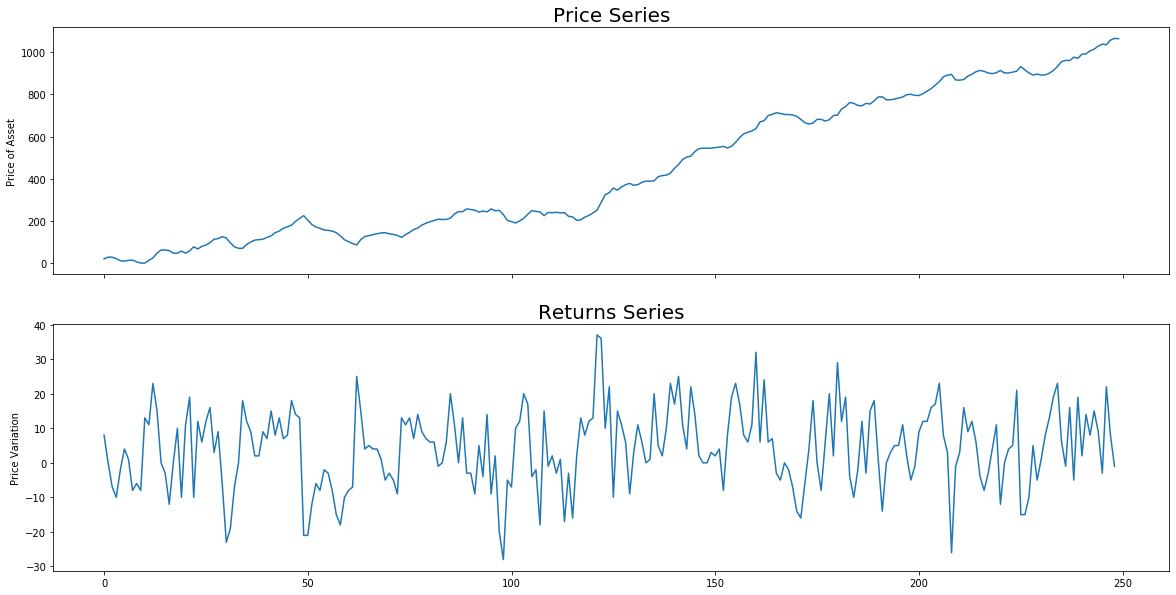

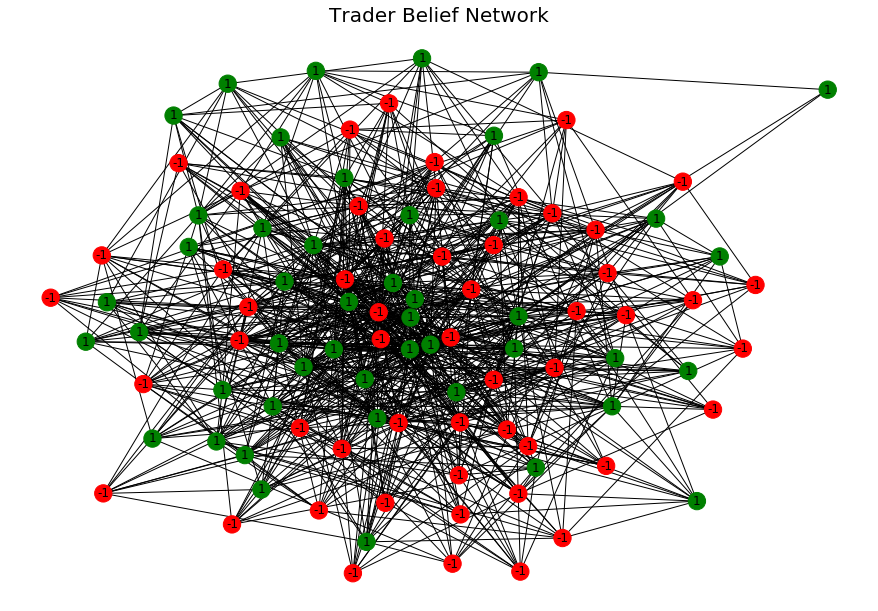

In [15]:
trader_network = generate_network()
run_simulation(individuality=50)

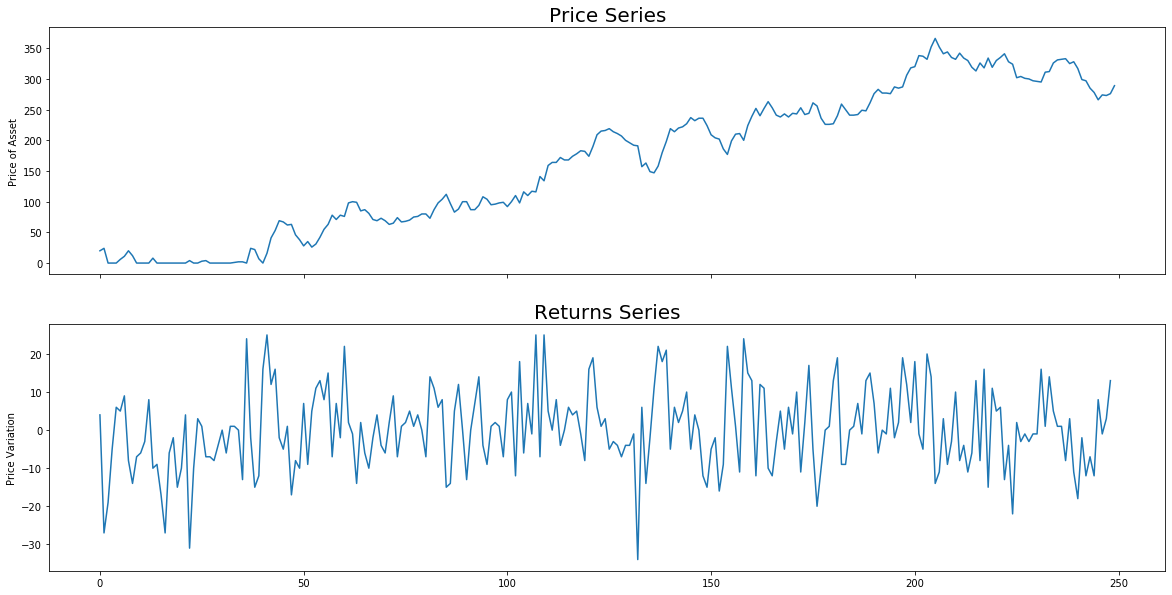

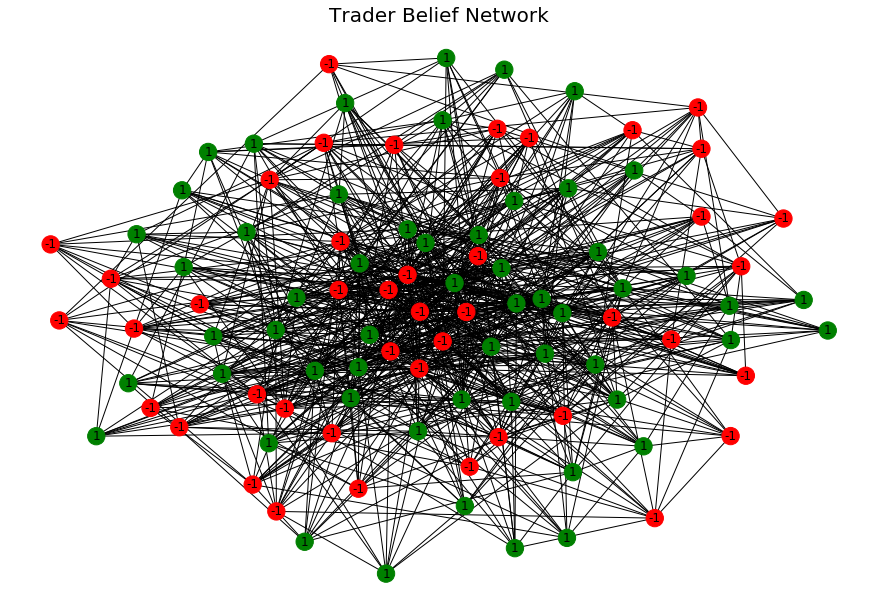

In [16]:
trader_network = generate_network()
run_simulation(individuality=100)

___
# Must adjust model to handle K proportionality constant instead of using `individuality` parameter
* These are cool results, but there is a problem with unrealistic magnitude in returns. Especially in the beggining when the price starts at 20, returns (because of the size of the network) can result in 100% swings in the price.
* Since, in genral, a price swing on any particular day is within the bounds of $\pm 1\%$, this is quite ridiculous.
* The reason is because I cowboyed my own `individuality` parameter instead of sticking close to the model and using the $K$ parameter, which accounts for the depth of the network.

## The two keys to this model:
1. The tendency or force toward imitation is governed by the parameter $K$, which can be called the "coupling strength."
2. The tendency towards idiosyncratic (or noisy) behavior is governed by the amplitude $\sigma$ of the noise term.